In [92]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv
import json
from PIL import Image

In [45]:
CWD = os.getcwd()
DATA_DIR = "bdd-sample"
BDD_IMAGES_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"images","train")
BDD_IMAGES_TEST = os.path.join(CWD,"resources",DATA_DIR,"images","test")
BDD_LABELS_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"labels","train")
BDD_LABELS_TEST = os.path.join(CWD,"resources",DATA_DIR,"labels","test")
BDD_SEGMENTED_TRAIN = os.path.join(CWD,"resources",DATA_DIR,"segmented","color_labels","train")
BDD_SEGMENTED_VAL = os.path.join(CWD,"resources",DATA_DIR,"segmented","color_labels","val")

In [48]:
# just change what these vars below equal to pull from diff sources
train_images_paths = sorted(os.listdir(BDD_IMAGES_TRAIN))
test_images_paths = sorted(os.listdir(BDD_IMAGES_TEST))

train_labels_paths = sorted(os.listdir(BDD_LABELS_TRAIN))
test_labels_paths = sorted(os.listdir(BDD_LABELS_TEST))

#seg_train_images_paths = sorted(os.listdir(BDD_SEGMENTED_TRAIN))
#seg_test_images_paths = sorted(os.listdir(BDD_SEGMENTED_VAL))

In [49]:
print(train_images_paths[0], train_labels_paths[0])
print(len(train_labels_paths),len(test_labels_paths))
#print(len(seg_train_images_paths),seg_train_images_paths[0])

000d4f89-3bcbe37a.jpg 000d4f89-3bcbe37a.json
1002 2002


## Load Images
Use Pillow cuz its easy, json.load()
Populate arrays containing image data and label data

In [166]:
#Load images based on a source directory where it comes from and the actual image
def load_images(images_dir,images_paths):
    images=[]
    for i in range(len(images_paths)):
        try:
            path = os.path.join(images_dir,images_paths[i])
            img = Image.open(path)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {images_paths[i]}: {e}")
    return np.array(images)

In [167]:
#Load labels based on a source directory where it comes from and the actual label
def load_labels(labels_dir,labels_paths):
    labels=[]
    for i in range(len(labels_paths)):
        with open(os.path.join(labels_dir,labels_paths[i]),"r") as file:
            parsed = json.load(file)
            labels.append(parsed)
    return labels

In [168]:
train_images = load_images(BDD_IMAGES_TRAIN,train_images_paths)
test_images = load_images(BDD_IMAGES_TEST,test_images_paths)
train_labels = load_labels(BDD_LABELS_TRAIN,train_labels_paths)
test_labels = load_labels(BDD_LABELS_TEST,test_labels_paths)

[[[137 165 169]
  [137 165 169]
  [137 165 169]
  ...
  [ 51  51  49]
  [ 51  51  49]
  [ 51  51  49]]

 [[137 165 169]
  [137 165 169]
  [137 165 169]
  ...
  [ 58  58  56]
  [ 58  58  56]
  [ 58  58  56]]

 [[137 165 169]
  [137 165 169]
  [137 165 169]
  ...
  [ 62  62  60]
  [ 62  62  60]
  [ 62  62  60]]

 ...

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [ 43  57  60]
  [ 43  57  60]
  [ 43  57  60]]

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [ 43  57  60]
  [ 43  57  60]
  [ 43  57  60]]

 [[  4   4   4]
  [  4   4   4]
  [  4   4   4]
  ...
  [ 43  57  60]
  [ 43  57  60]
  [ 43  57  60]]]
385.807881
(720, 1280, 3)


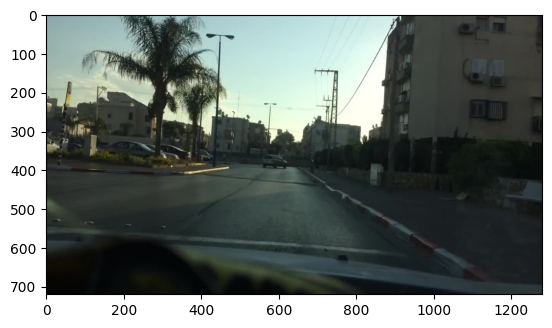

In [173]:
#testing out our data

print(train_images[0])
print(train_labels[0]["frames"][0]["objects"][0]["box2d"]["x1"])
#get set of objects: train_labels[0]["frames"][0]["objects"]
#each object: object["attributes"]["box2d"]["x1"|"x2"|"y1"|"y2"]

print(train_images[0].shape)

# BUG WITH IMSHOW: THE EDITOR INVERTS THE COLORS SO YEAH USE SAVEFIG
plt.imshow(train_images[0])
plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Work with images loaded

In [118]:
def get_objects(label):
    """
    For a label json object containing json data labeling an image, find labeled objects
    Note: some objects include drivable roadways: remove those
    :param label: json object containing data
    :return: labeled objects in image
    """
    all_objs = label["frames"][0]["objects"]
    objs=[]
    for ob in all_objs:
        if "box2d" in ob: #only objects that have a bounding box
            objs.append(ob)
    return objs


def get_box_from_object(object):
    """
    for a labeled object for an image, find its bounding box
    :param object: object from label
    :return: 4 coordinates: x1, y1,  x2, y2
    """
    return (object["box2d"]["x1"],object["box2d"]["y1"]),(object["box2d"]["x2"],object["box2d"]["y2"])

In [99]:
def draw_box_on_axes(axes, point1, point2):
    rect = patches.Rectangle(point1, point2[0] - point1[0], point2[1] - point1[1], linewidth=1, edgecolor='b', facecolor='none')
    axes.add_patch(rect)

test: draw boxes on features in the image

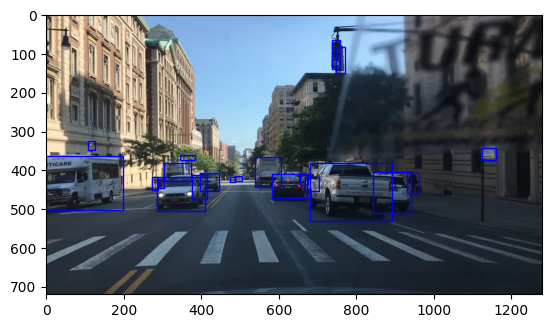

In [176]:
working = 5

img_1 = train_images[working]
label_1 = train_labels[working]
objects_1 = get_objects(label_1)

fig, ax = plt.subplots()

ax.imshow(img_1)

for obj in objects_1:
    pt1, pt2 = get_box_from_object(obj)
    draw_box_on_axes(ax,pt1,pt2)

plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

#plt.grid(False)